# Short Time Span Strat

In [31]:
import binance_helpers as bh
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import binance_downloader as bdl
import json
import requests
import ui
import time
import model as m
import matplotlib.pyplot as plt
client = bh.new_binance_client()



In [6]:
def get_backtesting_df(assets=None, length=None, quote="USDT", progress=False, sleep=0.5):
    """
    gets backtesting df with closing prices of all assets in profile.
    - assets: list of assets without quote
    - length: limit the length of the df
    - progress: to show progress bar or not
    - sleep: >=0. Time to sleep before binance call
    - save: whether to save the df
    """
    if assets is None: assets = m.get_all_assets()
    if "BTC" in assets: assets.remove("BTC")
    df = get_timeseries_data("BTCUSDT").close.rename("btc").to_frame()
    
    iteration = 0
    total = len(assets)
    
    for asset in assets:
        if progress: ui.printProgressBar(iteration, total)
        iteration += 1
        time.sleep(sleep)
        
        try:
            # new = (bdl.get_timeseries_data(asset+quote)['close']/df.btc).rename(asset.lower())
            new = get_timeseries_data(asset+quote)['close'].rename(asset.lower())
            df = pd.concat([df, new], axis=1)
        except:
            print(f"Warning: No symbol exists: {asset+quote}")
                    
    ui.printProgressBar(iteration, total)
        
    return df

In [7]:
def get_timeseries_data(pair:str):
    """gets the binance past timeseries"""    
    klines = client.get_historical_klines(pair, client.KLINE_INTERVAL_5MINUTE, "30 01 2022 00:00:00", limit=1000)
    df = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore'])
    df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
    df = df.astype(np.float64)
    df["timestamp"] = df.timestamp.astype(np.int64)
    df['timestamp'] = list(map(lambda x: datetime.utcfromtimestamp(x/1e3), df.timestamp))
    df = df.set_index('timestamp')
    return df

In [8]:
df = get_backtesting_df()

 |██████████████████████████████████████████████████| 100.0% 


In [12]:
df.to_csv("data/test.csv")

In [21]:
pct = (df - df.shift(1))/df.shift(1)
pct = pct.loc[:df.iloc[-5].name]
# pct.drop("btc", inplace=True, axis=1)
pct.drop("busd", inplace=True, axis=1)
pct.dropna(how="all", inplace=True)
pct.tail(3)

,btc,1inch,aave,aca,ada,agld,aion,akro,alcx,algo,...,xtz,xvs,xzc,yfii,yfi,ygg,zec,zen,zil,zrx
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-02-26 03:10:00,-0.004295,-0.004093,-0.003554,0.005912,-0.006536,-0.007563,-0.002478,-0.001505,-0.001502,-0.002719,...,-0.007681,-0.006417,NaN,-0.002001,-0.003664,-0.007094,-0.001837,0.000852,-0.004543,-0.003247
2022-02-26 03:15:00,0.001703,0.000685,0.002853,0.007557,0.003289,0.003387,0.001242,0.003014,0.000000,0.000593,...,0.000298,0.001076,NaN,0.000501,0.001355,0.001299,0.000920,0.000284,0.001201,0.000724
2022-02-26 03:20:00,-0.000724,-0.002738,-0.002134,0.003333,-0.002186,-0.005063,-0.002481,-0.000751,-0.006767,-0.003198,...,-0.005952,-0.002151,NaN,-0.005010,-0.002811,-0.002271,-0.004596,-0.003688,-0.004559,-0.004702


In [22]:
pct = pct.iloc[1:-1]

In [23]:
pct_ = pct

In [24]:
btc = pct_['btc']
pct_.drop("btc", inplace=True, axis=1)

In [25]:
pct_r = list(map(lambda x: pct_.iloc[x].sort_values(ascending=False).index, range(len(pct_))))

In [26]:
best = pct_r.copy()
best.insert(0, best[-1])
del best[-1]

In [27]:
def get_returns(pct, best, num=3, ith=0):
    returns = [0, 0]
    pret = [0, 0]
    trades = ["", ""]
    total = len(pct)
    for i in range(2, total):
        prev_ret = pct.iloc[i-1][best[i][ith]]
        # if best[i][0] not in mbi:
        #     returns.append(0)
        #     trades.append("")
        # elif prev_ret < -1.0:
        #     returns.append(0)
        #     trades.append("")
        # else:
        row = pct.iloc[i]
        # gain = sum(list(map(lambda x: row[best[i][x]], range(num))))/num
        gain = row[best[i][ith]]
        if np.isnan(gain):
            gain = 0
            trades.append("")
        else: 
            trades.append(best[i][ith])
        returns.append(-gain)
        pret.append(prev_ret)
        ui.printProgressBar(i, total)
    return returns, pret, trades


In [28]:
returns, pret, trades = get_returns(pct_, best, num=1, ith=0)

In [50]:
d_ = pd.DataFrame({"trades":trades, 'pret':pret, 'target':returns}, index=pct_.index)

In [83]:
d = d_[d_.pret>0.04]

In [84]:
r = list(map(lambda x: x-0.004 if x != 0 else x, d['target']))
i = -1
b = [None,None]

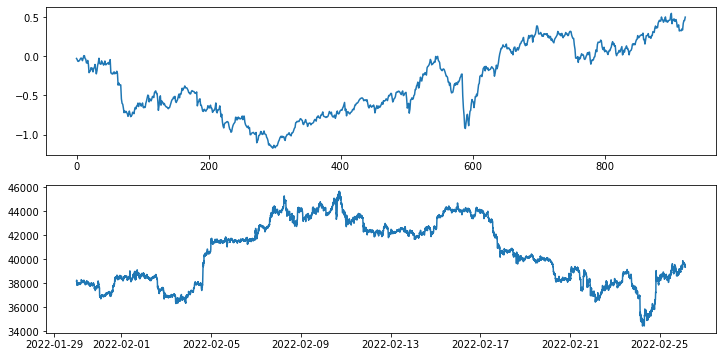

In [85]:
cumsum = pd.Series(r).cumsum()[b[0]:b[1]]
fig, ax = plt.subplots(2, figsize=(12, 6))
ax[0].plot(cumsum)
ax[1].plot(df.iloc[b[0]:b[1]].btc)

# cumsum.plot()